<a href="https://colab.research.google.com/github/oneonlee/NLP-author-classification/blob/main/LGE/BERT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

# Set environment variables for CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# Load data
path = '/content/drive/MyDrive/'
train_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test_x.csv')
submission_df = pd.read_csv(path+'/sample_submission.csv')


# Preprocess text data
train_text = train_df['text'].values
train_labels = train_df['author'].values
test_text = test_df['text'].values



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# Initialize the ALBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the input text data using the ALBERT tokenizer
input_ids = []
attention_masks = []

for text in tqdm(train_text, desc="Preprocessing training data"):
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Split the preprocessed training data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = \
    train_test_split(input_ids, train_labels, random_state=42, test_size=0.1, stratify=train_df['author'])
train_masks, validation_masks, _, _ = \
    train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1, stratify=train_df['author'])

# Set hyperparameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 16
epochs = 3
learning_rate = 5e-5



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Preprocessing training data: 100%|██████████| 54879/54879 [01:36<00:00, 568.82it/s]


평균 단어 길이 (train, test)

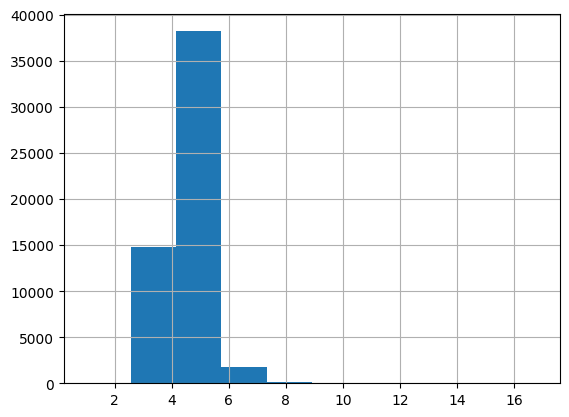

In [5]:
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

plot_word_length_histogram(train_df['text'])
     

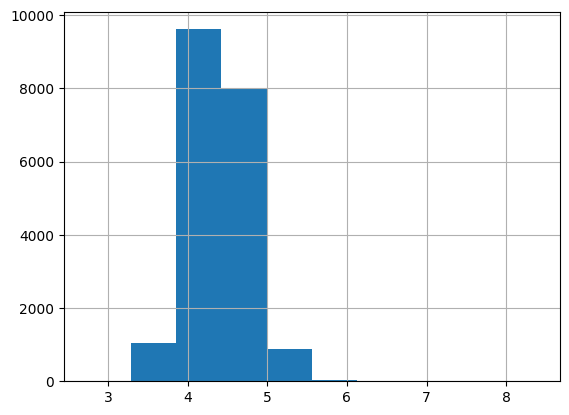

In [6]:
plot_word_length_histogram(test_df['text'])

stopwords 분포

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


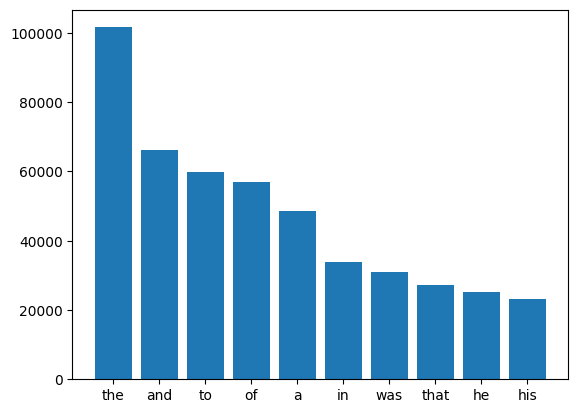

In [10]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(train_df['text'])  

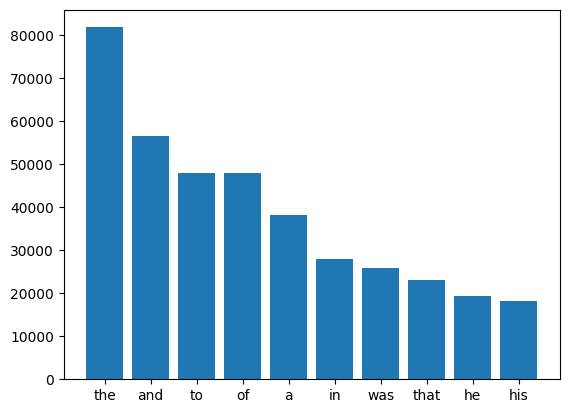

In [12]:
plot_top_stopwords_barchart(test_df['text'])   

작가별 stopwords 분포

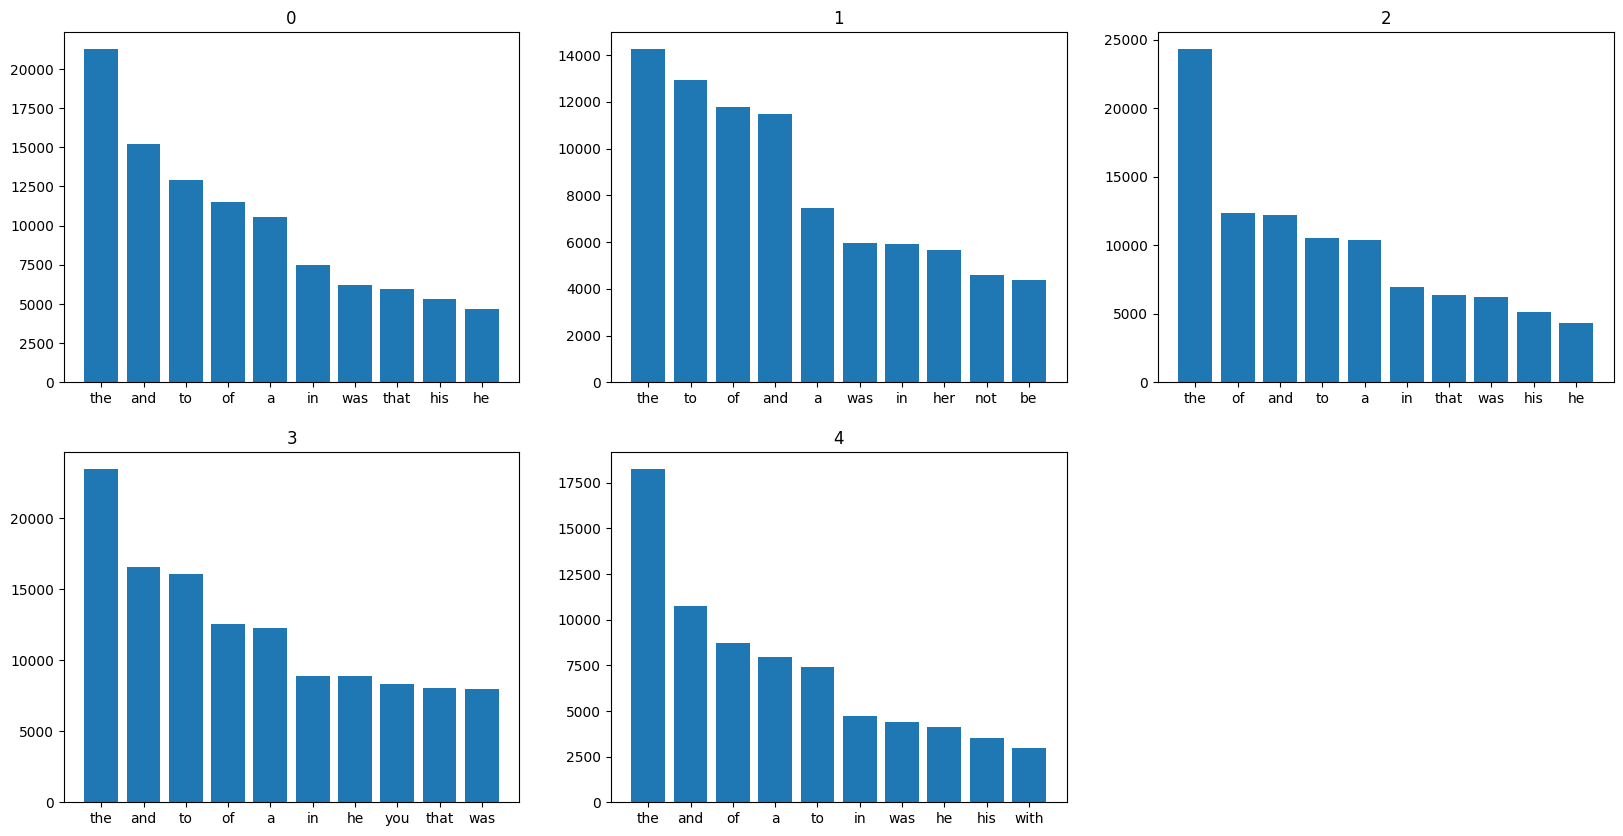

In [16]:
fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart2(train_df[train_df['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x,y)    

corpus 빈도

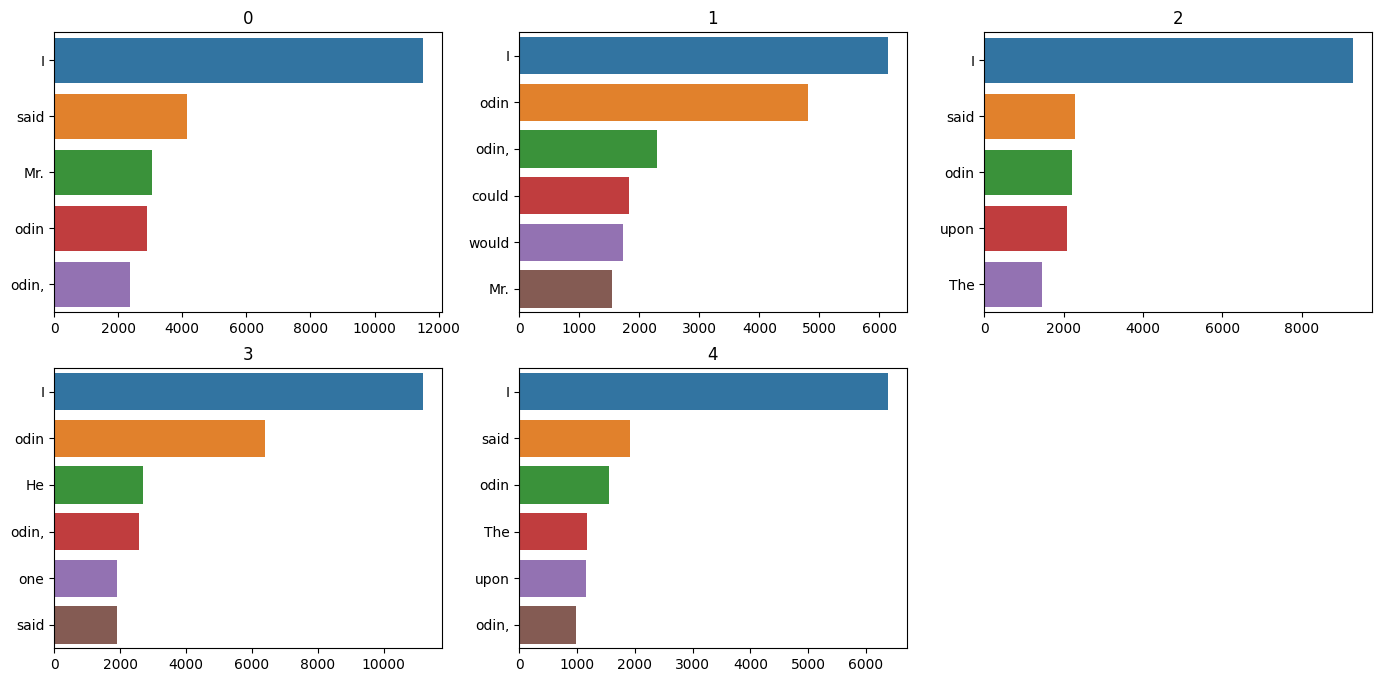

In [22]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter


fig = plt.figure(figsize=(17,8))
rows = 2
cols = 3

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart(train_df[train_df['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

odin 제외 (odin이 없는 data를 학습시킬 경우에 대비하여 stopword로 train에서만 유독 많았던 odin을 제외하는 것도 나쁘지 않아보임)

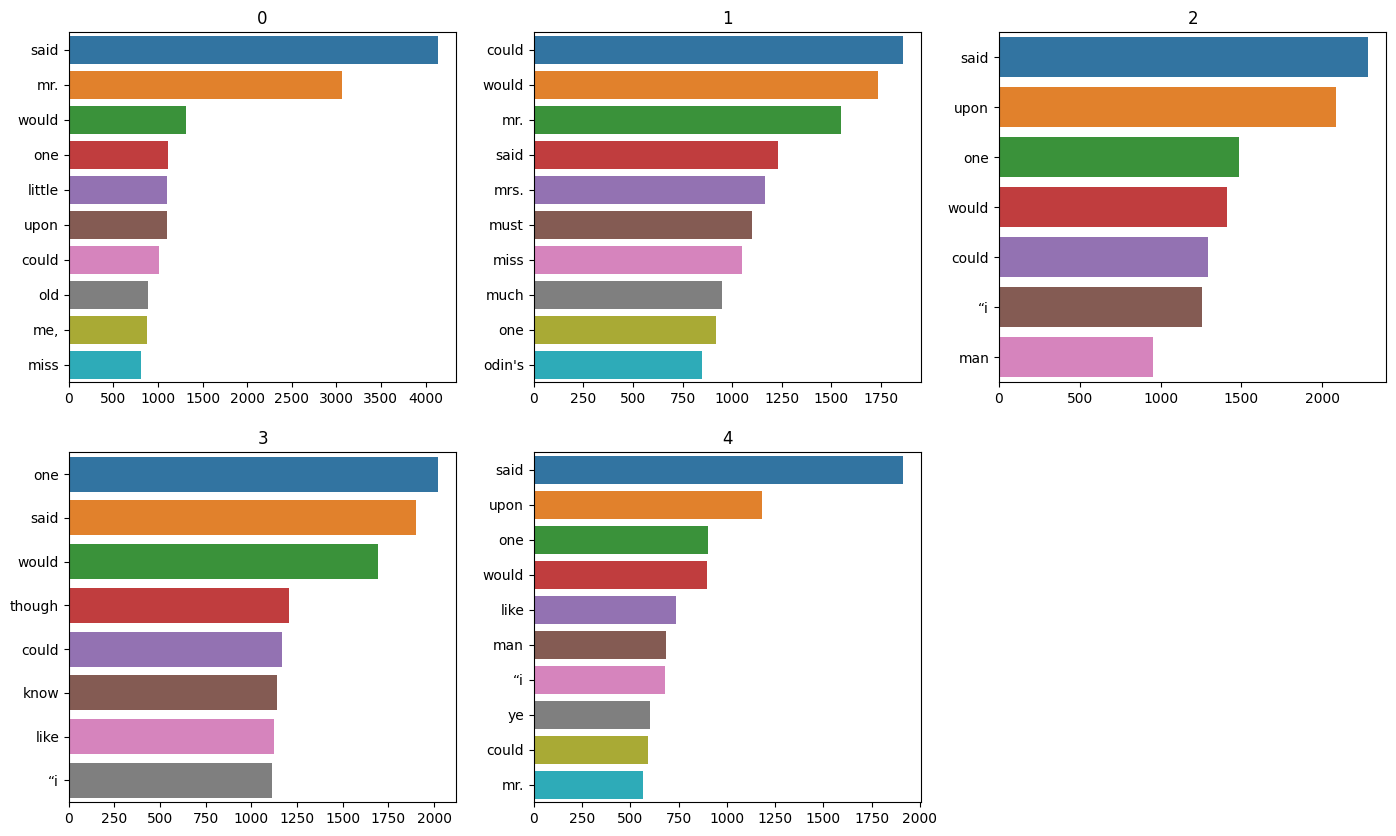

In [31]:
# 소문자 처리
train_df['text_l'] = train_df['text'].str.lower() 
test_df['text_l'] = test_df['text'].str.lower() 

fig = plt.figure(figsize=(17,10))
rows = 2
cols = 3


def plot_top_non_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    stop.update(['odin', 'odin,', 'odin.'])

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:70]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart2(train_df[train_df['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

Ngram

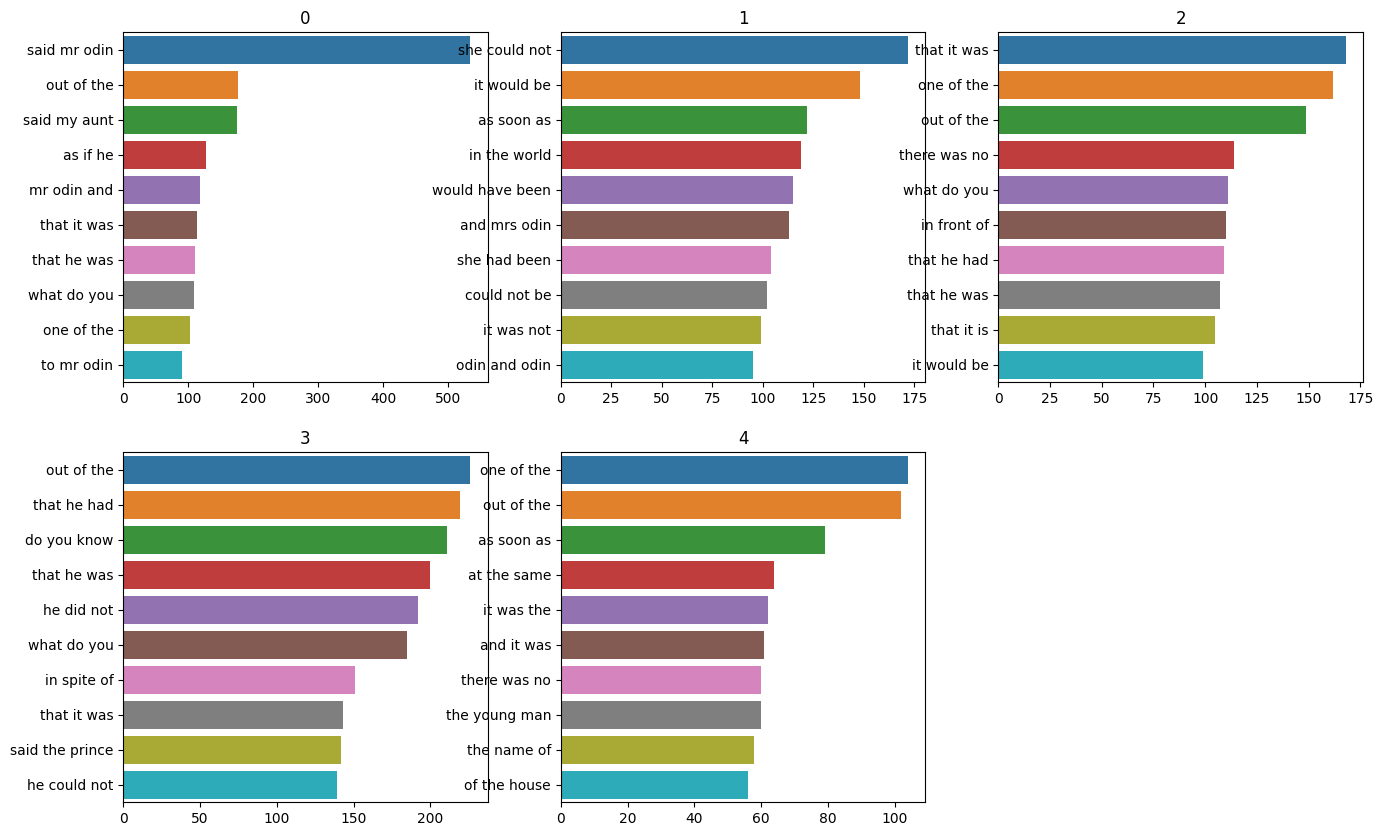

In [34]:
fig = plt.figure(figsize=(16,10))
rows = 2
cols = 3

def plot_top_ngrams_barchart2(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return x, y

for i in range(5):
    x,y = plot_top_ngrams_barchart2(train_df[train_df['author']==i]['text_l'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

In [35]:
# Convert inputs, masks, and labels to tensors
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Create a TensorDataset
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# Create a DataLoader for training data
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create a TensorDataset for validation data
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# Create a DataLoader for validation data
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)
model.to(device)

# Set optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
# num_training_steps = epochs * len(train_data) // batch_size
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=num_training_steps)



<ipython-input-35-850106a981ee>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-35-850106a981ee>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
<ipython-input-35-850106a981ee>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
<ipython-input-35-850106a981ee>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(

Wordcloud

In [60]:
from wordcloud import WordCloud, STOPWORDS
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

def plot_wordcloud(text):
    

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

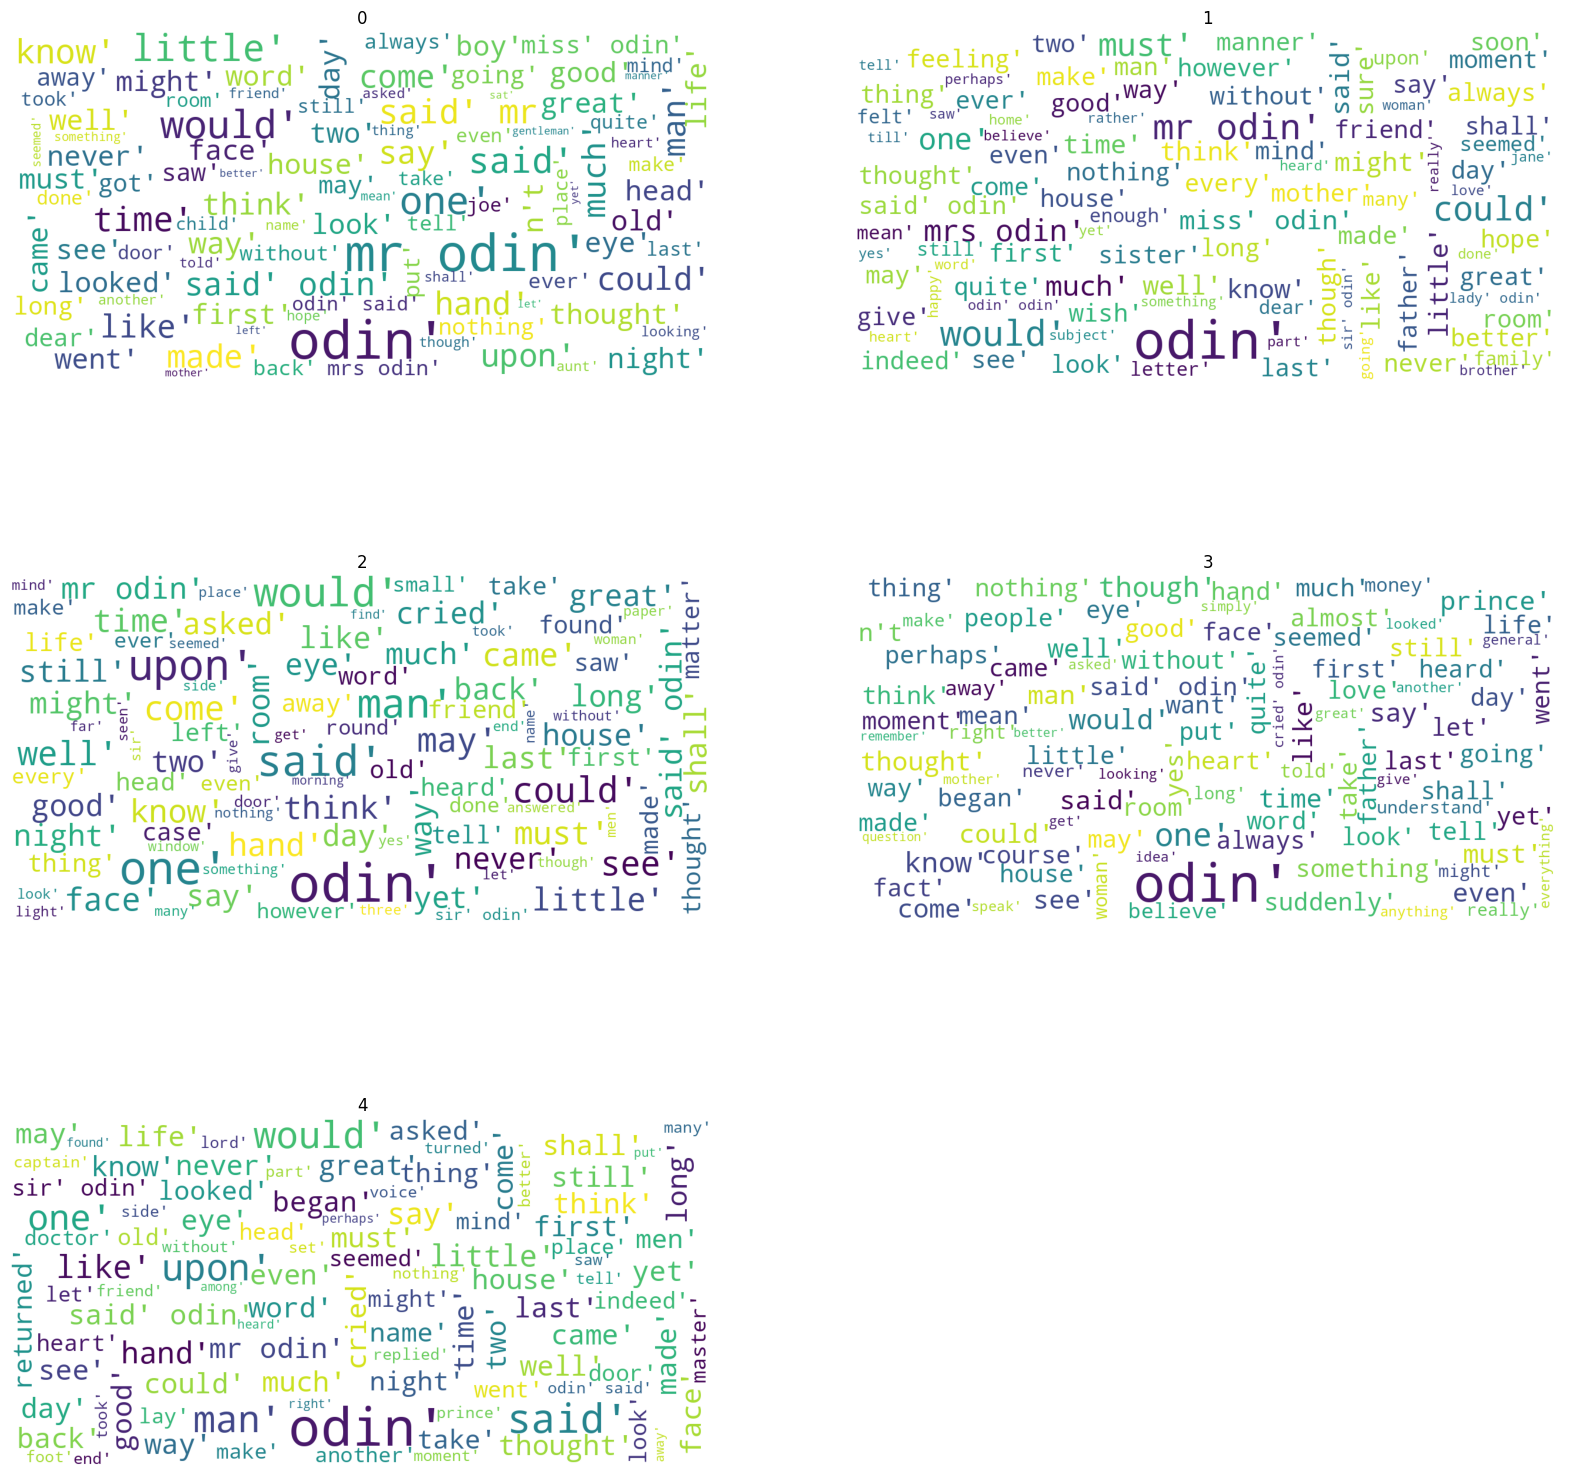

In [62]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud(train_df[train_df['author']==i]['text_l'])
    ax = fig.add_subplot(rows, cols, i+1)
    
    #fig = plt.figure(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)
    #plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


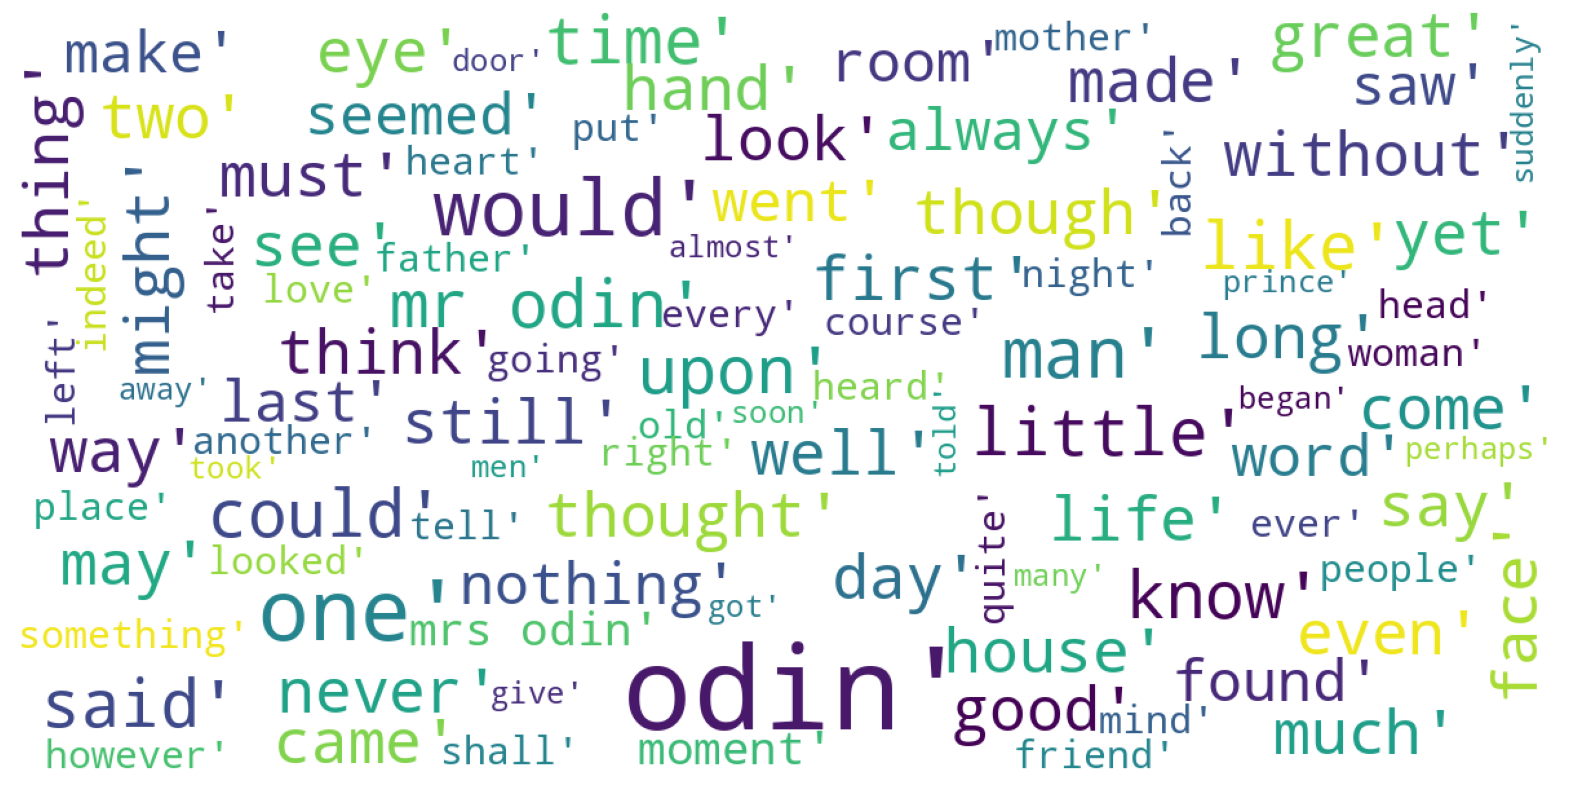

In [64]:
wordcloud = plot_wordcloud(test_df['text_l'])
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis('off')
ax.imshow(wordcloud)

epoch에 따른 loss 그래프와 epoch에 따른 정확도 그래프

RAM 사용량 초과로 실행이 안되어 제대로 그래프를 출력하는지 확인하지는 못했다.

수정--

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
train_acc = []
val_acc = []
best_accuracy = 0.0

for epoch in range(1, epochs+1):
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch[0].to(device=device)
        attention_masks = batch[1].to(device=device)
        labels = batch[2].to(device=device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs[1], dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_acc.append(train_accuracy)
    
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch}/{epochs}, training loss: {avg_train_loss}, training accuracy: {train_accuracy}')

    model.eval()
    
    validation_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(validation_dataloader):
        input_ids = batch[0].to(device=device)
        attention_masks = batch[1].to(device=device)
        labels = batch[2].to(device=device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            validation_loss += loss.item()
            
        _, predicted = torch.max(outputs[1], dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    avg_val_loss = validation_loss / len(validation_dataloader)
    valid_losses.append(avg_val_loss)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        model.save_pretrained('bert-classifier')

    val_log_loss = log_loss(labels.cpu(), logits.cpu())
    print(f'Epoch {epoch}/{epochs}, validation loss: {avg_val_loss}, validation log loss: {val_log_loss}, validation accuracy: {val_accuracy}')

    model.save_pretrained('bert-classifier')

# plot the training and validation losses over epochs
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the training and validation accuracy over epochs
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

  0%|          | 0/3087 [00:00<?, ?it/s]

max_length 매개변수 최적 값을 선택히 귀위해 전처리 후 인코딩된 입력 시퀀스의 길이 분포를 보여주는 그래프를 그렸다.

그래프를 보고 가장 일반적인 길이를 확인하여 max_length로 이용할 수 있다.

이는 입력 시퀀스가 잘리거나 과도하게 패딩되지 않도록하는데 도움을 줄 수 있다.

In [ ]:
수정--

입력 텍스트 데이터에서 가장 자주 사용되는 상위 10개 단어를 시각화하는 코드도 추가했다.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Preprocessing test data: 100%|██████████| 19617/19617 [01:10<00:00, 278.37it/s]


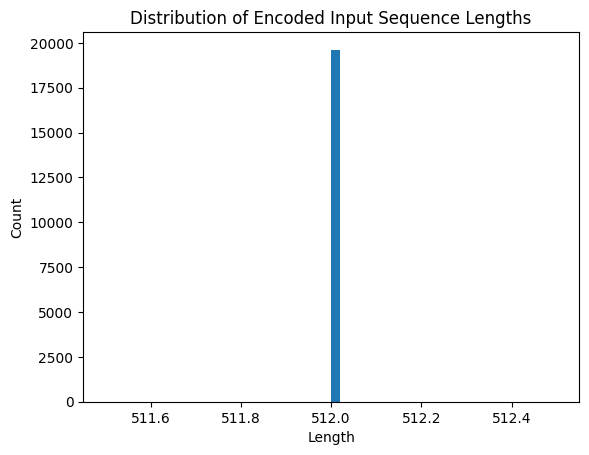

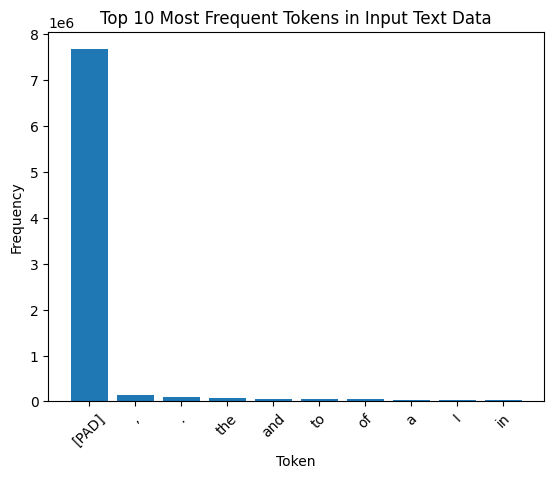

In [77]:

# Tokenize the input text data using the BERT tokenizer
input_ids = []
attention_masks = []

tokens = []

for text in tqdm(test_text, desc="Preprocessing test data"):
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

    tokens += tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0].tolist())

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

token_counts = Counter(tokens)

top_tokens = token_counts.most_common(10)
top_token_counts = [count for _, count in top_tokens]
top_token_labels = [token for token, _ in top_tokens]

import matplotlib.pyplot as plt

# Get the length of each encoded input sequence
lengths = [len(input_id) for input_id in input_ids]

# Plot a histogram of the length distribution
plt.hist(lengths, bins=50)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Encoded Input Sequence Lengths')
plt.show()

# Plot a bar chart of the top 10 most frequent tokens
plt.bar(top_token_labels, top_token_counts)
plt.xticks(rotation=45)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tokens in Input Text Data')
plt.show()


In [76]:

# Set up the data loader for test data
test_data = TensorDataset(input_ids, attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Make predictions
model.eval()
test_preds = []

for batch in tqdm(test_dataloader, desc="Making predictions"):
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)

    # Truncate the input sequences that are longer than 512 tokens
    if input_ids.shape[1] > 512:
        input_ids = input_ids[:, :512]
        attention_masks = attention_masks[:, :512]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    test_preds.append(logits)

    test_preds = np.concatenate(test_preds, axis=0)

# Create submission file
submission_df[['0', '1', '2', '3', '4']] = test_preds
submission_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Making predictions:   0%|          | 0/1227 [00:09<?, ?it/s]


KeyboardInterrupt: ignored